## CS441: Applied ML - HW 2

### Parts 1-2: MNIST

Include all the code for generating MNIST results below

In [ ]:
# initialization code
import numpy as np
from keras.datasets import mnist
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.linear_model import LogisticRegression


def load_mnist():
  '''
  Loads, reshapes, and normalizes the data
  '''
  (x_train, y_train), (x_test, y_test) = mnist.load_data() # loads MNIST data
  x_train = x_train[::-1]
  y_train = y_train[::-1]
  x_train = np.reshape(x_train, (len(x_train), 28*28))  # reformat to 784-d vectors
  x_test = np.reshape(x_test, (len(x_test), 28*28))
  maxval = x_train.max()
  x_train = x_train/maxval  # normalize values to range from 0 to 1
  x_test = x_test/maxval
  return (x_train, y_train), (x_test, y_test)

def display_mnist(x, subplot_rows=1, subplot_cols=1):
  '''
  Displays one or more examples in a row or a grid
  '''
  if subplot_rows>1 or subplot_cols>1:
    fig, ax = plt.subplots(subplot_rows, subplot_cols, figsize=(15,15))
    for i in np.arange(len(x)):
      ax[i].imshow(np.reshape(x[i], (28,28)), cmap='gray')
      ax[i].axis('off')
  else:
      plt.imshow(np.reshape(x, (28,28)), cmap='gray')
      plt.axis('off')
  plt.show()

### Part 1: PCA and Data Compression

Compute the principal components using sklearn.decomposition.PCA over the full training set.  

a. Display the first 10 principal components using the same
tool that is used to display centroids.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


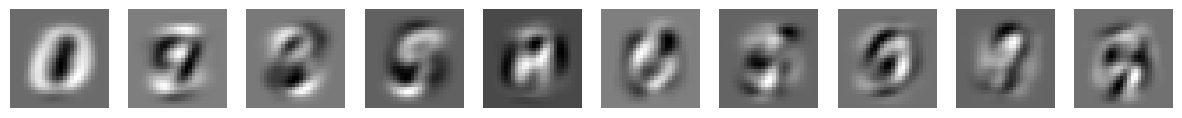

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = load_mnist()

# Compute the first 10 principal components using x_train

# TO DO

# Apply PCA to the training data
pca = PCA()
pca.fit(x_train)

# Get First 10 Components
first_10_components = pca.components_[:10]

display_mnist(first_10_components,1,10)


b. Scatterplot the first two dimensions of PCA-transformed x_train[:500]. Show a different color for each digit label.


<Axes: >

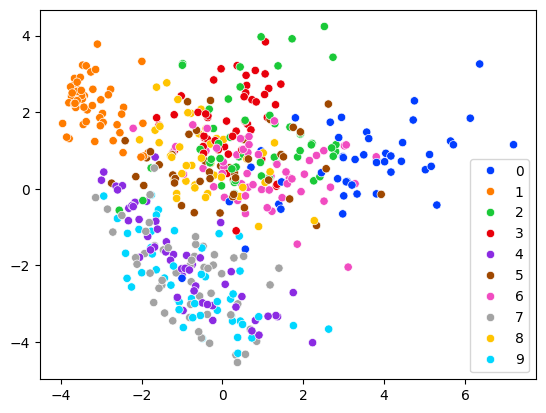

In [ ]:
# Scatter plot of first two PCA dimensions
import seaborn as sns

# use pca.transform
# TO DO
pca = PCA(n_components=2)
x = pca.transform(x_train[:500])

ind = np.arange(500)
sns.scatterplot(x=x[ind,0],y=x[ind,1], hue=y_train[ind], palette="bright")

c. Plot cumulative explained variance (explained_variance_ratio_) of all components.

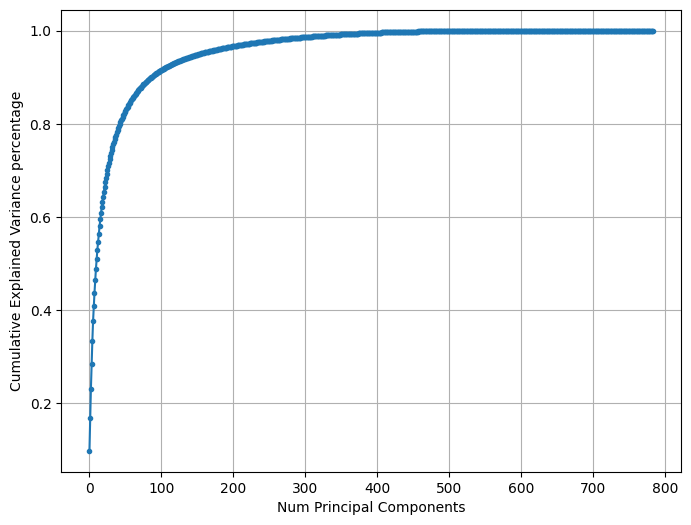

In [ ]:
# Plot cumulative explained variance ratio
# cumsum and pca.explained_variance_ratio_ will be useful

# TO DO

# Calculate cumulative explained variance (CEV)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot CEV
plt.figure(figsize=(8, 6))
plt.plot(cumulative_variance, marker='.')

# Add labels
plt.xlabel('Num Principal Components')
plt.ylabel('Cumulative Explained Variance percentage')

# Display the plot
plt.grid(True)
plt.show()

pre-d. Sanity Check for:

> Select the smallest number M of principal components that explains at least 90% of variance

ChatGPT code to modify graph in part c to visualize the 90% coverage:

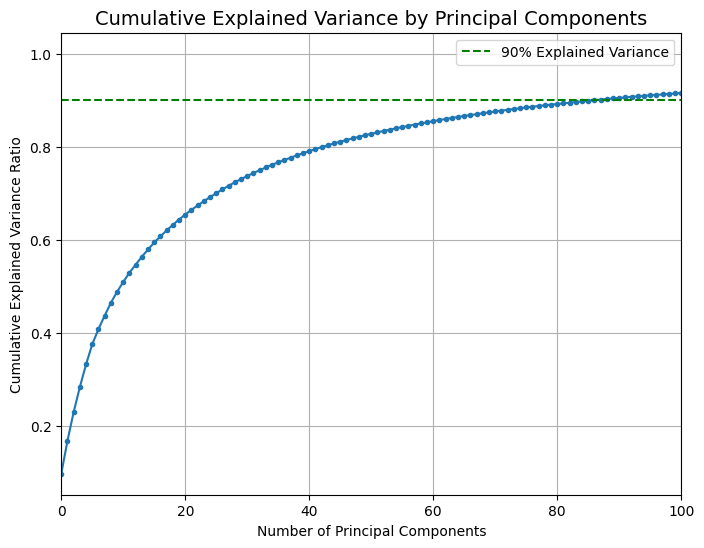

In [ ]:
# Compute cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(cumulative_variance, marker='.')

# Add a horizontal line at y=0.9 (90% explained variance)
plt.axhline(y=0.9, color='g', linestyle='--', label='90% Explained Variance')

# Optionally shorten the x-axis to focus on the first 100 principal components
plt.xlim(0, 100)  # Adjust this to zoom into the first 100 components

# Add labels and title
plt.title('Cumulative Explained Variance by Principal Components', fontsize=14)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')

# Add a legend for the 90% line
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

d. Select the smallest number M of principal components that explains at least 90% of variance. Then, compress the training data and the test data using the first M principal components, and compute the total time and test error for 1-NN using the brute force Faiss method. One set of principal components should be computed using train and applied to both train and test data. Compare time and error for 1-NN using original vs compressed features.

In [ ]:
# Select number of dimensions that explains 90% of variance, according to your plot above
!apt install libomp-dev > /dev/null 2>&1
!pip install faiss-cpu > /dev/null 2>&1
import faiss
import time

# ChatGPT revision of my calculate_error function from mp1 using np vectorization
# ^^ Since my calculate_error function was affecting time measurements
def calculate_error(y_true, y_pred):
  """
  Calculate the percent error between true labels and predicted labels.

  Args:
  y_true: True labels
  y_pred: Predicted labels

  Returns:
  percent_error: Percentage of incorrect predictions
  """
  return np.mean(y_pred != y_true) * 100

# Repurpose FAISS 1-NN code from mp1 into a general brute force function
def faiss_1nn(x_train, y_train, x_test, y_test):
  """
  This function computes 1-NN using FAISS brute-force.

  Args:
  y_true: True labels
  y_pred: Predicted labels

  Returns:
  percent_error: Percentage of incorrect predictions
  timing: Recorded time for faiss brute-force search
  """

  # Time the search and compute the nearest neighbor
  start_time = time.time()

  # Brute-force search with FAISS prep
  features_count = x_train.shape[1]
  index = faiss.IndexFlatL2(features_count)
  index.add(x_train.astype(np.float32))

  # Brute-force search with FAISS
  D, I = index.search(x_test.astype(np.float32), 1)
  y_pred = y_train[I].flatten()

  # Calculate percent error for brute-force search
  percent_error = calculate_error(y_test, y_pred)

  timing = time.time() - start_time
  return percent_error, timing  # Return the error and the time taken


''' Get time and error when using original features with brute force 1-NN '''

# Measure time and compute error for the original features
error, timing = faiss_1nn(x_train, y_train, x_test, y_test)
print(f'Original ----------\nTime: {timing:.2f} seconds\nTest Error: {error:.2f}%\n------------------')


''' Get time and error when using compressed features with brute force 1-NN '''

# Find the number of components it takes to reach 90%
main_components = np.argmax(cumulative_variance >= 0.90) + 1 # the data is 0 indexed so we need to +1
print(f'\n{main_components} principal components make up 90% of the variance!\n')
print(f'\n{len(cumulative_variance)} total principal componentse!\n')

# Compress the training data and the test data using the first M principal components
pca_90 = PCA(main_components)
x_train_compressed = pca_90.fit_transform(x_train)
x_test_compressed = pca_90.transform(x_test)

# Measure time and compute error for the compressed features
error, timing = faiss_1nn(x_train_compressed, y_train, x_test_compressed, y_test)
print(f'Compressed -------\nTime: {timing:.2f} seconds\nTest Error: {error:.2f}%\n------------------')


Original ----------
Time: 20.31 seconds
Test Error: 3.09%
------------------

87 principal components make up 90% of the variance!


784 total principal componentse!

Compressed -------
Time: 2.98 seconds
Test Error: 2.66%
------------------


### Part 2: MNIST Classification with Linear Models

We revisit classification using linear logistic regression (LLR) and SVM. For logistic regression, use `sklearn.linear_model.LogisticRegression` with default parameters (unless stated otherwise), except `max_iter=500`. For SVM, use `sklearn.svm.LinearSVC` with default parameters, except `max_iter=500`.  Do not use `svm.SVC` since that is a non-linear SVM by default.  With  `max_iter=500`, it's ok if you get a warning that it hasn’t converged.  

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm

# Define training sizes
training_sets = [100, 1000, 10000, 60000]

a. LLR/SVM vs training size: For varying size training sets N in [100, 1000, 10000, 60000], compare and tabulate classification error for linear logistic regression and linear SVM, using x_train[:N] and x_test.    

In [ ]:
# LLR
# TO DO

# Initialize LLR
llr = LogisticRegression(max_iter=500)

for N in training_sets:
  # Train LLR
  llr.fit(x_train[:N], y_train[:N])
  llr_pred = llr.predict(x_test)

  # Calculate and Display Error
  llr_error = calculate_error(y_test, llr_pred)
  print(f"Training Set Size: {N} has LLR error: {llr_error:.2f}%")


Training Set Size: 100 has LLR error: 49.80%
Training Set Size: 1000 has LLR error: 18.08%
Training Set Size: 10000 has LLR error: 9.47%
Training Set Size: 60000 has LLR error: 7.41%


In [ ]:
# SVM
# TO DO

# Initialize SVM
svm_model = svm.LinearSVC(max_iter=500)

for N in training_sets:

  # Train SVM
  svm_model.fit(x_train[:N], y_train[:N])
  svm_pred = svm_model.predict(x_test)

  # Calculate and Display Error
  svm_error = calculate_error(y_test, svm_pred)
  print(f"Training Set Size: {N} has SVM error: {svm_error:.2f}%")

Training Set Size: 100 has SVM error: 53.54%
Training Set Size: 1000 has SVM error: 20.55%
Training Set Size: 10000 has SVM error: 10.75%
Training Set Size: 60000 has SVM error: 8.16%


b. Error visualization: For each LLR and SVM, for each label (0 to 9), display the sample with the highest score for the *correct label*. E.g., out of all samples with a true label of 0, select the one that has the highest score for label 0. Display the 10 samples in a row for each method, showing the easy cases for each model.  Then, for each label, display the sample with the lowest score for the correct label. Again, display the 10 samples in a row, showing the difficult cases.

LLR (top row = highest score, bottom row = lowest score): 


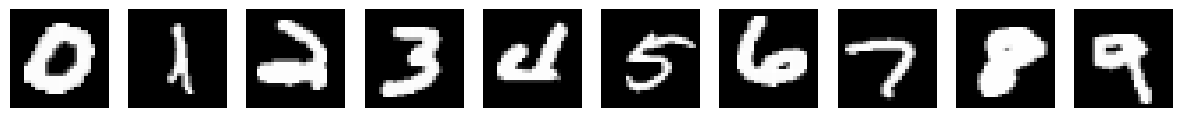

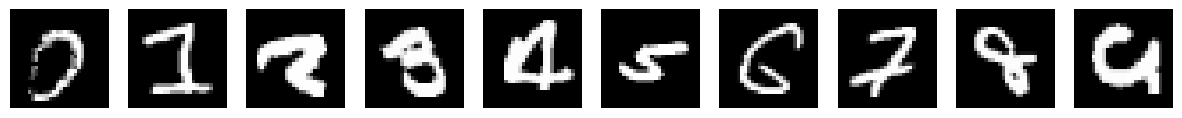

SVM (top row = highest score, bottom row = lowest score): 


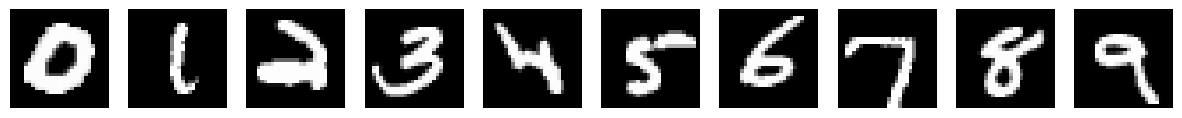

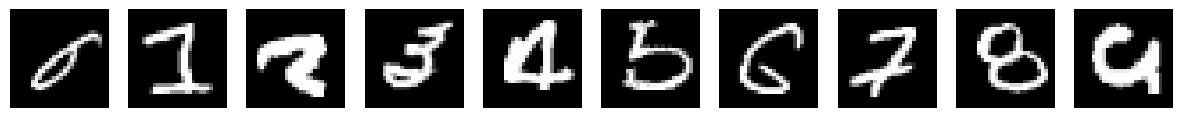

In [ ]:
# to get scores for logistic regression use: scores = model_lr.predict_proba(x_test)
# TO DO

'''
Sources:
https://www.geeksforgeeks.org/understanding-the-predictproba-function-in-scikit-learns-svc/
https://www.slingacademy.com/article/numpy-creating-an-array-with-true-false-based-on-an-existing-array/
'''

scores_llr = llr.predict_proba(x_test)

highest_llr = []
lowest_llr = []

for digit in range(10):
  # Boolean mask that filters the rows of scores_llr to match digit
  digit_indices = (y_test == digit)

  # Filter the probabilities for digit using the Boolean mask
  filtered_scores = scores_llr[digit_indices, digit]

  # Find index of the highest score among the filtered samples for digit
  highest_score_index = np.argmax(filtered_scores)
  # Retrieve the sample with the highest score
  highest_sample = x_test[digit_indices][highest_score_index]
  # Append highest sample to highest_llr list
  highest_llr.append(highest_sample)

  # Find index of the highest score among the filtered samples for digit
  lowest_score_index = np.argmin(filtered_scores)
  # Retrieve the sample with the lowest score
  lowest_sample = x_test[digit_indices][lowest_score_index]
  # Append lowest sample to lowest_llr list
  lowest_llr.append(lowest_sample)

print("LLR (top row = highest score, bottom row = lowest score): ")
display_mnist(highest_llr, 1, 10)
display_mnist(lowest_llr, 1, 10)

# to get scores for SVM use: scores = model_svm.decision_function(x_test)
# TO DO

scores_svm = svm_model.decision_function(x_test)

highest_svm = []
lowest_svm = []

for digit in range(10):
  # Boolean mask that filters the rows of scores_svm to match digit
  digit_indices = (y_test == digit)

  # Filter the probabilities for digit using the Boolean mask
  filtered_scores = scores_svm[digit_indices, digit]

  # Find index of the highest score among the filtered samples for digit
  highest_score_index = np.argmax(filtered_scores)
  # Retrieve the sample with the highest score
  highest_sample = x_test[digit_indices][highest_score_index]
  # Append highest sample to highest_svm list
  highest_svm.append(highest_sample)

  # Find index of the highest score among the filtered samples for digit
  lowest_score_index = np.argmin(filtered_scores)
  # Retrieve the sample with the lowest score
  lowest_sample = x_test[digit_indices][lowest_score_index]
  # Append lowest sample to lowest_svm list
  lowest_svm.append(lowest_sample)

print("SVM (top row = highest score, bottom row = lowest score): ")
display_mnist(highest_svm, 1, 10)
display_mnist(lowest_svm, 1, 10)

c. Parameter selection: For linear SVM, use validation experiments (testing on the validation set) to estimate the best regularization strength `C`. Then evaluate a model trained with that C on the test set. For the sake of speed, in this section, use  `x_train[:1000]` as the training set for all experiments, with `max_iter=1000`.  For the validation set, use `x_train[50000:]`.

In selection, try to get the best result on the validation set within 0.1%.  To select `C`, start with the default and increase/decrease by a factor of 2 until results either level out or start to get worse. Then, you can try half way between the most two best values. E.g. try `C` in [0.25, 0.5, 1, 2, 4].  Suppose 0.5 and 1 give the best results.  Then, try 0.75.  Once the difference between the two best results is less than 0.1%, you can stop. You can also search outside of this range if 0.25 or 4 gives the best result.  Plot the validation error for each `C` value tested on a semilogx plot, and record the best in a table.

C = 0.25: Validation Error = 20.37%
C = 0.5: Validation Error = 20.95%
C = 1: Validation Error = 21.30%
C = 2: Validation Error = 21.40%
C = 4: Validation Error = 21.44%
C = 0.125: Validation Error = 19.69%
C = 0.0625: Validation Error = 18.94%
C = 0.03125: Validation Error = 18.60%
C = 0.015625: Validation Error = 18.50%
C = 0.0078125: Validation Error = 18.63%
C = 0.0234375: Validation Error = 18.53%


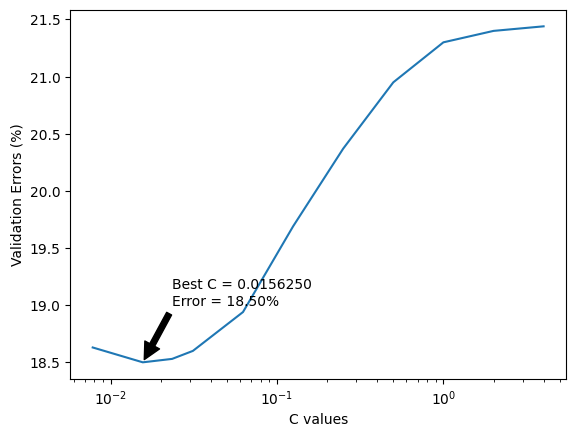

Best C = 0.015625, Best Validation Error = 18.50%


In [ ]:
# Try multiple C parameters, select one that minimizes validation error
# Often, you need to try a few values and see those results to determine what other values to try

# TO DO

# To select C, start with the default and increase/decrease by a factor of 2
# until results either level out or start to get worse. Then, you can try half way
# between the most two best values
def get_new_C(best_C, second_best_C, C_values):
  return best_C / 2 if best_C == min(C_values) else (best_C + second_best_C) / 2

# Extract values to find where C value converges on error bound
def update_best_values(val_error, new_C, best_error, best_C, second_best_error, second_best_C):
    if val_error < best_error:
        second_best_error = best_error
        second_best_C = best_C
        best_error = val_error
        best_C = new_C
    elif val_error < second_best_error:
        second_best_error = val_error
        second_best_C = new_C

    return best_error, best_C, second_best_error, second_best_C

# Split training set into training and validation sets
x_train_2c = x_train[:1000]
y_train_2c = y_train[:1000]
x_val = x_train[50000:]
y_val = y_train[50000:]

# Define C values to track
C_values = [0.25, 0.5, 1, 2, 4]
best_C = None
second_best_C = None

# Define error valuse to track
validation_errors = []
best_error = np.inf
second_best_error = np.inf

# try C in [0.25, 0.5, 1, 2, 4] first
for C in C_values:
  # Initialize and fit SVC model
  svm_model = svm.LinearSVC(C=C, max_iter=1000)
  svm_model.fit(x_train_2c, y_train_2c)

  # Get predictions for validation set
  y_val_pred = svm_model.predict(x_val)

  # Calculate validation error
  val_error = calculate_error(y_val, y_val_pred)
  validation_errors.append(val_error)

  # Store the best C and error to converge to local min
  best_error, best_C, second_best_error, second_best_C = update_best_values(
    val_error, C, best_error, best_C, second_best_error, second_best_C
  )

  print(f"C = {C}: Validation Error = {val_error:.2f}%")

# While error does not reduce by 0.1% (converge)
while not (abs(best_error - second_best_error) < 0.1):
  new_C = get_new_C(best_C, second_best_C, C_values)

  # Initialize and fit SVC model
  svm_model = svm.LinearSVC(C=new_C, max_iter=1000)
  svm_model.fit(x_train_2c, y_train_2c)

  # Get predictions for validation set
  y_val_pred = svm_model.predict(x_val)

  # Calculate validation error
  val_error = calculate_error(y_val, y_val_pred)
  validation_errors.append(val_error)
  C_values.append(new_C)

  best_error, best_C, second_best_error, second_best_C = update_best_values(
    val_error, new_C, best_error, best_C, second_best_error, second_best_C
  )

  print(f"C = {new_C}: Validation Error = {val_error:.2f}%")

# ChatGPT function to fix graph line drawings
sorted_C_values, sorted_validation_errors = zip(*sorted(zip(C_values, validation_errors)))

# Plot validation error vs C values
plt.semilogx(sorted_C_values, sorted_validation_errors)  # Plot sorted C values for continuity
plt.xlabel('C values')
plt.ylabel('Validation Errors (%)')

# ChatGPT code for sanity check
best_index = validation_errors.index(best_error)  # Find the index of the best error
best_C_value = C_values[best_index]
plt.annotate(f'Best C = {best_C_value:.7f}\nError = {best_error:.2f}%',
             xy=(best_C_value, best_error),  # Position of the annotation
             xytext=(best_C_value * 1.5, best_error + 0.5),  # Position for the text
             arrowprops=dict(facecolor='black', shrink=0.05))  # Draw an arrow

plt.show()

print(f"Best C = {best_C}, Best Validation Error = {best_error:.2f}%")

In [ ]:
# Get test result for selected parameter

# TO DO

# Select the best C value based on lowest valid error
prev_C = C_values[np.argmin(validation_errors)]
print(f"Best C val: {prev_C}")

# Train the model with the best C
final_svm_model = svm.LinearSVC(C=prev_C, max_iter=1000)
final_svm_model.fit(x_train, y_train)

# Get predictions based on C value for valid set
y_test_pred = final_svm_model.predict(x_test)

# Calculate test error based on best C value
test_error = calculate_error(y_test, y_test_pred)
print(f"Test Error for model with parameter C = {prev_C}: {test_error:.2f}%")


Best C val: 0.015625
Test Error for model with parameter C = 0.015625: 8.28%


## Part 3: Temperature Regression

We will investigate using linear regression for both prediction and feature selection.


In [ ]:
import numpy as np
from google.colab import drive
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# load data (modify to match your data directory or comment)
def load_temp_data():
  drive.mount('/content/drive')
  datadir = "/content/drive/My Drive/CS441/24FA/hw2/"
  T = np.load(datadir + 'temperature_data.npz')
  xt_train, yt_train, xt_val, yt_val, xt_test, yt_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day = \
  T['x_train'], T['y_train'], T['x_val'], T['y_val'], T['x_test'], T['y_test'], T['dates_train'], T['dates_val'], T['dates_test'], T['feature_to_city'], T['feature_to_day']
  return (xt_train, yt_train, xt_val, yt_val, xt_test, yt_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day)

# plot one data point for listed cities and target date
def plot_temps(x, y, cities, feature_to_city, feature_to_day, target_date):
  nc = len(cities)
  ndays = 5
  xplot = np.array([-5,-4,-3,-2,-1])
  yplot = np.zeros((nc,ndays))
  for f in np.arange(len(x)):
    for c in np.arange(nc):
      if cities[c]==feature_to_city[f]:
        yplot[feature_to_day[f]+ndays,c] = x[f]
  plt.plot(xplot,yplot)
  plt.legend(cities)
  plt.plot(0, y, 'b*', markersize=10)
  plt.title('Predict Temp for Cleveland on ' + target_date)
  plt.xlabel('Day')
  plt.ylabel('Avg Temp (C)')
  plt.show()


Mounted at /content/drive
Feature 361: city = Cleveland, day= -1
Baseline - prediction using previous day: RMSE=3.460601246750482


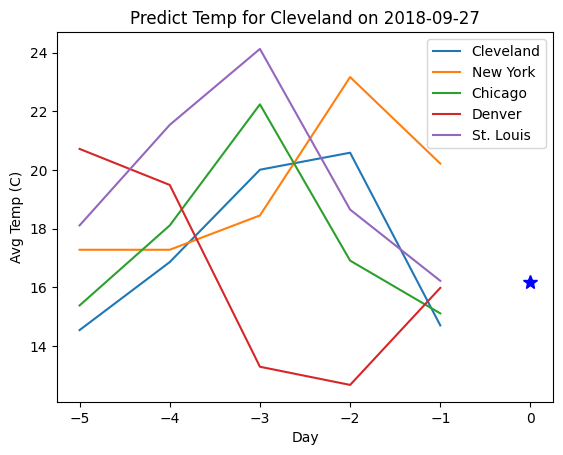

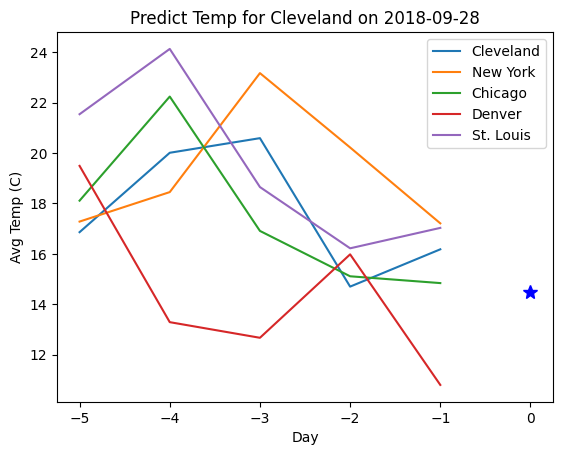

In [ ]:
# load data
(xt_train, yt_train, xt_val, yt_val, xt_test, yt_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day) = load_temp_data()
''' Data format:
      x_train, y_train: features and target value for each training sample (used to fit model)
      x_val, y_val: features and target value for each validation sample (used to select hyperparameters, such as regularization and K)
      x_test, y_test: features and target value for each test sample (used to evaluate final performance)
      dates_xxx: date of the target value for the corresponding sample
      feature_to_city: maps from a feature number to the city
      feature_to_day: maps from a feature number to a day relative to the target value, e.g. -2 means two days before
      Note: 361 is the temperature of Cleveland on the previous day
'''
f = 361
print('Feature {}: city = {}, day= {}'.format(f,feature_to_city[f], feature_to_day[f]))
baseline_rmse = np.sqrt(np.mean((yt_val[1:]-yt_val[:-1])**2)) # root mean squared error
print('Baseline - prediction using previous day: RMSE={}'.format(baseline_rmse))

# plot first two x/y for val
plot_temps(xt_val[0], yt_val[0], ['Cleveland', 'New York', 'Chicago', 'Denver', 'St. Louis'], feature_to_city, feature_to_day, dates_val[0])
plot_temps(xt_val[1], yt_val[1], ['Cleveland', 'New York', 'Chicago', 'Denver', 'St. Louis'], feature_to_city, feature_to_day, dates_val[1])



a. Train and Test Linear Regression (LR):
Report RMSE results for L2-regularized linear regression (`sklearn.linear_model.Ridge`)  using default regularization parameters on the temperature regression dataset, using original and normalized features (based on feature number 361, as defined in HW1). When normalizing, remember to normalize both the training and the test sets.

In [ ]:
def normalize_features(x, y, fnum):
  ''' Normalize the features in x and y.
      For each data sample i:
        x2[i] = x[i]-x[i,fnum]
        y2[i] = y[i]-x[i,fnum]
  '''
  x2 = x.copy()
  y2 = y.copy()
  for i in np.arange(len(x)):
    x2[i] = x[i] - x[i, fnum]
    y2[i] = y[i] - x[i,fnum]
  return x2, y2

In [ ]:
 # linear regression (use Ridge)

# original features
# TO DO

# Initialize and train Ridge on training set
ridge = Ridge()
ridge.fit(xt_train, yt_train)

# Calculate predictions on the test set
yt_pred = ridge.predict(xt_test)

# Calculate and print RMSE using the test set
rmse_original = np.sqrt(np.mean((yt_test - yt_pred) ** 2))
print(f'Ridge Regression (Original Features) - Test RMSE: {rmse_original}')

# normalized features
# TO DO

fnum = 361 # previous day temp in Cleveland

# Normalize both training and test sets based on fnum from HW1
xt_train_norm, yt_train_norm = normalize_features(xt_train, yt_train, fnum=fnum)
xt_test_norm, yt_test_norm = normalize_features(xt_test, yt_test, fnum=fnum)

# Initialize and train Ridge on normalized training set
ridge_norm = Ridge()
ridge_norm.fit(xt_train_norm, yt_train_norm)

# Calculate predictions on the test set
yt_pred_norm = ridge_norm.predict(xt_test_norm)

# Calculate and print RMSE for normalized test set
rmse_normalized = np.sqrt(np.mean((yt_test_norm - yt_pred_norm) ** 2))
print(f'Ridge Regression (Normalized Features) - Test RMSE: {rmse_normalized}')

Ridge Regression (Original Features) - Test RMSE: 2.0240941104705374
Ridge Regression (Normalized Features) - Test RMSE: 2.0364796152456446


b. Feature selection: Use original features for this part.  Identify the most important features by: (1) fitting a L1 Linear Regression model (`sklearn.linear_model.Lasso`) with default parameters; and (2) selecting the features that have coefficient magnitudes greater than 0.001 (`model.coef_` is the linear coefficient vector; -0.02 and 0.02 both have magnitude greater than 0.001).  For the top 10 features, report their indices and corresponding city and day. Also report the test RMSE error rates of L2 (ridge) linear regression when trained using only the top 10 selected features.

In [ ]:
# feature analysis (select important features using Lasso)
# TO DO

# Initialize and train Lasso on training set
lasso = Lasso()
lasso.fit(xt_train, yt_train)

# ChatGPT spitted out np.where
top_features = np.where(np.abs(lasso.coef_) > 0.001)[0] # (-0.02 is valid so take absolute)
print(f'Top 10 features:')

# predict using best features
# TO DO

# Display top 10 features and their city + day
top_features = top_features[:10]
for f in top_features:
    print(f'Feature {f}: city = {feature_to_city[f]}, day = {feature_to_day[f]}')

# Initialize and train Lasso on top 10 features
xt_train_top = xt_train[:, top_features]
xt_test_top = xt_test[:, top_features]

ridge_top = Ridge()
ridge_top.fit(xt_train_top, yt_train)

# Predict and evaluate on validation set
yt_pred_top = ridge_top.predict(xt_test_top)
rmse_top = np.sqrt(np.mean((yt_test - yt_pred_top) ** 2))
print(f'Ridge top 10 Features RMSE: {rmse_top}')

Top 10 features:
Feature 9: city = Boston, day = -5
Feature 19: city = Queens, day = -5
Feature 37: city = Virginia Beach, day = -5
Feature 175: city = Boston, day = -3
Feature 241: city = Albany, day = -3
Feature 264: city = Minneapolis, day = -2
Feature 307: city = Omaha, day = -2
Feature 334: city = Chicago, day = -1
Feature 347: city = Minneapolis, day = -1
Feature 361: city = Cleveland, day = -1
Ridge top 10 Features RMSE: 2.196470907376893


## Part 4: Stretch Goals
Include all your code used for any stretch goals in this section. Add headings where appropriate.

a.  **PR and ROC curves**: Often, we want to evaluate performance in a threshold-invariant way, or to see how classification varies with the confidence threshold. For LLR with default parameters, create precision-recall and ROC plots for predicting whether a digit is a “0” vs. not “0”.  You can use any libraries to do this. Also report AP and area under the curve (AUC).  


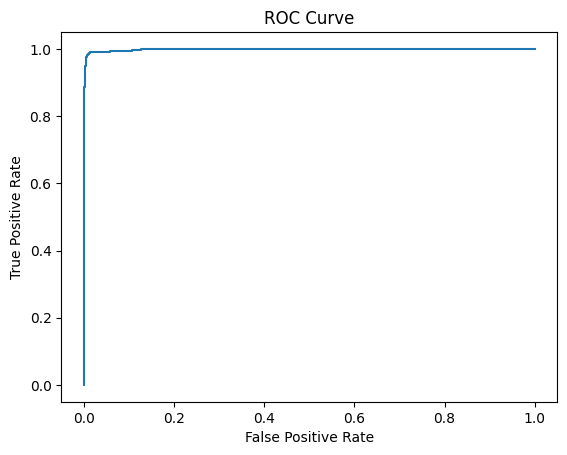

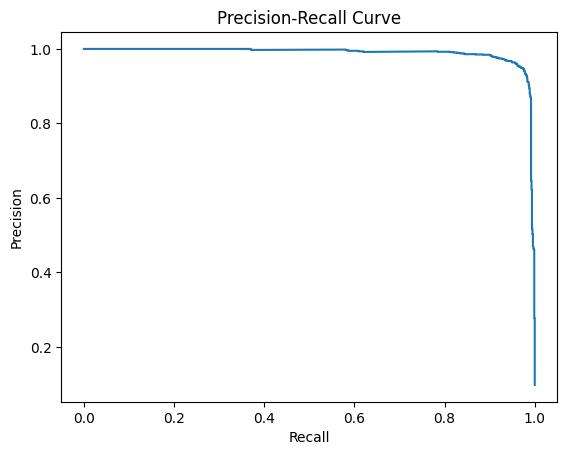

ROC AUC: 1.00
Average Precision (AP): 0.99


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

# Initialize and train LLR
llr = LogisticRegression(max_iter=500)
llr.fit(x_train, y_train == 0)

# Get predicted probabilities
y_proba = llr.predict_proba(x_test)[:, 1]

# Convert y_test binary mask like earlier (2.b)
y_test_binary = (y_test == 0)

# ROC Plot using label 0 as Bool
false_pos_rate, true_pos_rate, _ = roc_curve(y_test_binary, y_proba)
roc_auc = roc_auc_score(y_test_binary, y_proba)

# Precision-Recall Plot
precision, recall, _ = precision_recall_curve(y_test_binary, y_proba)
average_precision = average_precision_score(y_test_binary, y_proba)

# Plot ROC graph
plt.figure()
plt.plot(false_pos_rate, true_pos_rate)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Plot Precision-Recall Curve
plt.figure()
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Report AUC and AP
print(f'ROC AUC: {roc_auc:.2f}')
print(f'Average Precision (AP): {average_precision:.2f}')


**b. Visualize weights**: For each digit (0–9), display the linear classifier weights as an image.  Put all the images in a row.  Do this for the LLR weights using L1, L2, and elastic regularization and for SVM weights. It’s OK to use a smaller training size for this, e.g. first 1000 samples – the main purpose is to visualize how regularization affects the weights.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: 

Visualizing Logistic Regression with L1 Regularization Weights


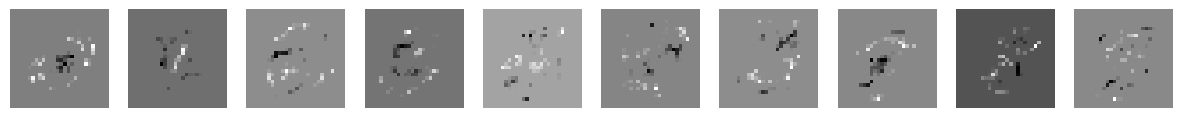

Visualizing Logistic Regression with L2 Regularization Weights


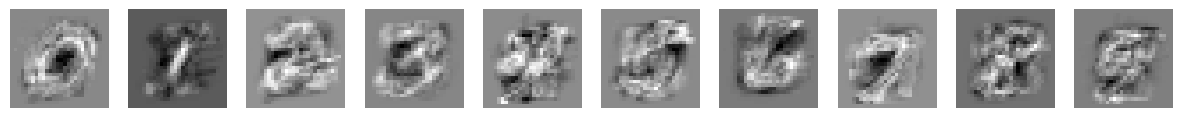

Visualizing Logistic Regression with Elastic Net Regularization Weights


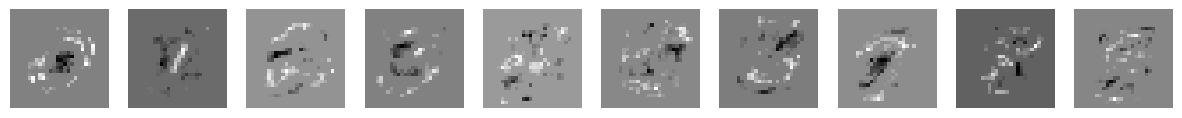

Visualizing SVM with L2 Regularization Weights


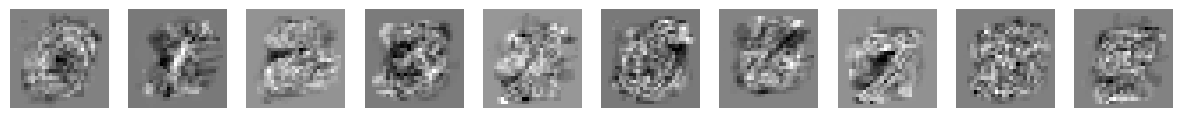

In [ ]:
x_train_4b, y_train_4b = x_train[:1000], y_train[:1000]

# Used ChatGPT to solve penalty error (had to add multi_class and solver parameters to use l1 and elasticnet)

# L1 Regularization (Lasso LLR)
llr_l1 = LogisticRegression(penalty='l1', solver='saga', max_iter=500, multi_class='multinomial')
llr_l1.fit(x_train_4b, y_train_4b)
l1_weights = llr_l1.coef_

# L2 Regularization (Ridge LLR)
llr_l2 = LogisticRegression(penalty='l2', solver='saga', max_iter=500, multi_class='multinomial')
llr_l2.fit(x_train_4b, y_train_4b)
l2_weights = llr_l2.coef_

# Elastic Net Regularization (Lasso + Ridge LLR)
llr_elastic = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=500, multi_class='multinomial')
llr_elastic.fit(x_train_4b, y_train_4b)
elastic_weights = llr_elastic.coef_

# SVM with L2 Regularization
svm_model = svm.LinearSVC(penalty='l2', max_iter=500, multi_class='ovr')
svm_model.fit(x_train_4b, y_train_4b)
svm_weights = svm_model.coef_

# Visualize how regularization affects the weights

print("Visualizing Logistic Regression with L1 Regularization Weights")
display_mnist(l1_weights, 1, 10)

print("Visualizing Logistic Regression with L2 Regularization Weights")
display_mnist(l2_weights, 1, 10)

print("Visualizing Logistic Regression with Elastic Net Regularization Weights")
display_mnist(elastic_weights, 1, 10)

print("Visualizing SVM with L2 Regularization Weights")
display_mnist(svm_weights, 1, 10)

c. **Other embeddings**: Extending Part 1b, plot 2D points of x_train[:500] using at least two of t-SNE, MDS, UMAP, and Linear Discriminant Analysis, and display these plots alongside the PCA scatterplot. You may fit/train on 500 points as well.

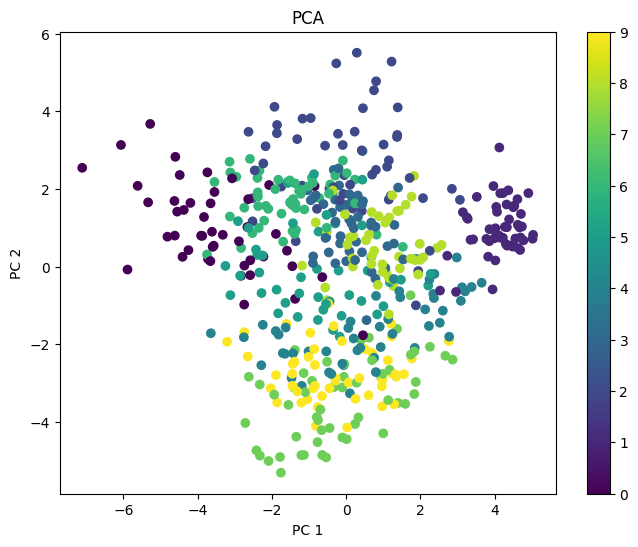

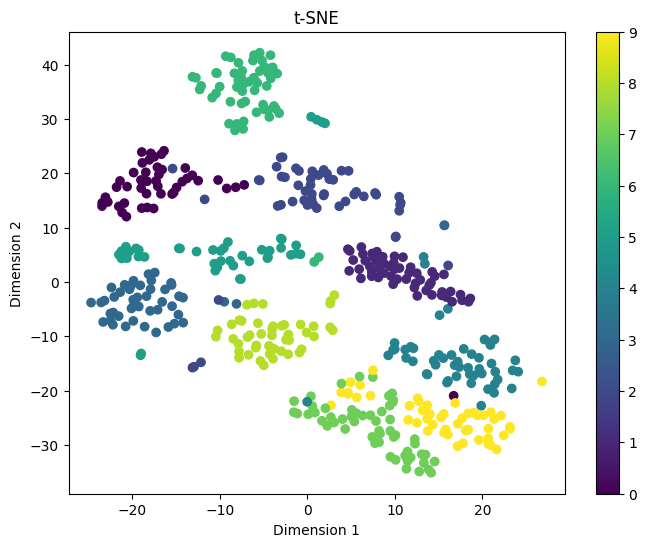

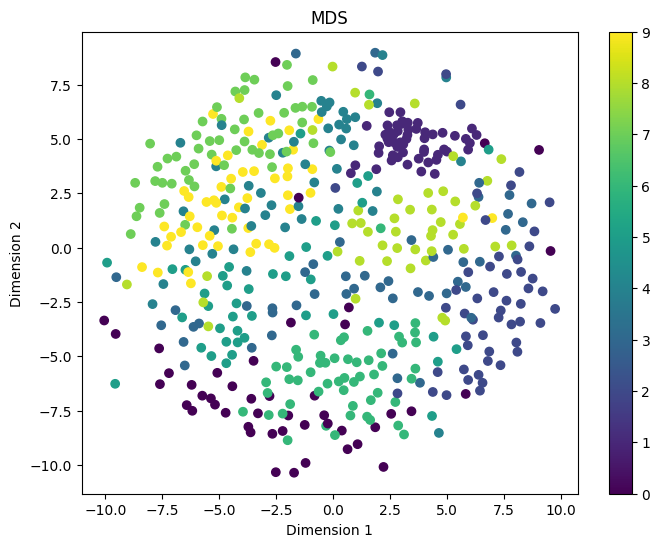

In [ ]:
from sklearn.manifold import TSNE, MDS

# Compute the PCA, t-SNE, and MDS embeddings
pca = PCA(n_components=2).fit_transform(x_train[:500])
tsne = TSNE(n_components=2).fit_transform(x_train[:500])
mds = MDS(n_components=2).fit_transform(x_train[:500])

''' Display and analyze embedding plots '''
# PCA
plt.figure(figsize=(8, 6))
plt.scatter(pca[:, 0], pca[:, 1], c=y_train[:500], cmap='viridis')
plt.title('PCA')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.colorbar()
plt.show()

# t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(tsne[:, 0], tsne[:, 1], c=y_train[:500], cmap='viridis')
plt.title('t-SNE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.colorbar()
plt.show()

# MDS
plt.figure(figsize=(8, 6))
plt.scatter(mds[:, 0], mds[:, 1], c=y_train[:500], cmap='viridis')
plt.title('MDS')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.colorbar()
plt.show()

d. **One city is all you need?** Suppose you are only allowed to know the temperature for one city from the previous five days. You can use any feature normalization or regression model.  Which city is best, and what RMSE do you get in testing?  Remember that for model selection (including choosing a city), you should use a validation set, only testing once you have made a selection.  Explain your process.

In [ ]:
from sklearn.metrics import mean_squared_error

# Initialize values
best_city = None
lowest_rmse = np.inf
rmse_results = {}

cities = np.unique(feature_to_city)

for city in cities:
  # Select data for this city
  city_features = [i for i, c in enumerate(feature_to_city) if c == city and feature_to_day[i] in [-5, -4, -3, -2, -1]]
  xt_train_city = xt_train[:, city_features]
  xt_val_city = xt_val[:, city_features]

  # Initialize Ridge regression model
  ridge = Ridge()
  ridge.fit(xt_train_city, yt_train)

  # Make predictions on the validation set
  yt_val_pred = ridge.predict(xt_val_city)

  # Calculate RMSE for this city
  rmse = np.sqrt(mean_squared_error(yt_val, yt_val_pred))
  rmse_results[city] = rmse

  # Check if this city gives the lowest RMSE so far
  if rmse < lowest_rmse:
    lowest_rmse = rmse
    best_city = city

# Output the best city from validation results
print(f"Best city: {best_city} with validation RMSE: {lowest_rmse:.4f}")

# test best city on the test set
city_features = [i for i, c in enumerate(feature_to_city) if c == best_city and feature_to_day[i] in [-5, -4, -3, -2, -1]]
xt_test_city = xt_test[:, city_features]

# Initialize Ridge regression model
ridge_test = Ridge()
ridge_test.fit(xt_train_city, yt_train)
yt_test_pred = ridge_test.predict(xt_test_city)
test_rmse = np.sqrt(mean_squared_error(yt_test, yt_test_pred))

print(f"Test RMSE for {best_city}: {test_rmse:.4f}")

Best city: St. Louis with validation RMSE: 2.7103
Test RMSE for St. Louis: 3.4076


e. **SVM with RBF Kernel**: Compare results across training sizes for linear SVM (LinearSVC) and SVM with an RBF kernel, which is the default kernel when using SVC. For linear, you can copy-paste your results from 1a.

In [ ]:
# Initialize SVMs
linear_svm = svm.LinearSVC(max_iter=10000)
rbf_svm = svm.SVC(kernel='rbf', max_iter=10000)

# Define the training sizes
training_sizes = [100, 1000, 10000, 60000]

linear_svm_errors = []
rbf_svm_errors = []

for size in training_sizes:
    # Train SVMs
    linear_svm.fit(x_train[:size], y_train[:size])
    rbf_svm.fit(x_train[:size], y_train[:size])

    # Calculate the errors
    linear_svm_errors.append(calculate_error(y_test, linear_svm.predict(x_test)))
    rbf_svm_errors.append(calculate_error(y_test, rbf_svm.predict(x_test)))

# Compare the errors
for size, linear_err, rbf_err in zip(training_sizes, linear_svm_errors, rbf_svm_errors):
    print(f'Training size: {size}, Linear SVM error: {linear_err:.2f}%, RBF SVM error: {rbf_err:.2f}%')


Training size: 100, Linear SVM error: 53.54%, RBF SVM error: 49.02%
Training size: 1000, Linear SVM error: 20.55%, RBF SVM error: 13.09%
Training size: 10000, Linear SVM error: 10.75%, RBF SVM error: 3.88%
Training size: 60000, Linear SVM error: 8.16%, RBF SVM error: 2.08%


In [ ]:
# from https://gist.github.com/jonathanagustin/b67b97ef12c53a8dec27b343dca4abba
# install can take a minute

import os
# @title Convert Notebook to PDF. Save Notebook to given directory
NOTEBOOKS_DIR = "/content/drive/My Drive/CS441/24FA/hw2" # @param {type:"string"}
NOTEBOOK_NAME = "CS441_FA24_HW2_Solution.ipynb" # @param {type:"string"}
#------------------------------------------------------------------------------#
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
NOTEBOOK_PATH = f"{NOTEBOOKS_DIR}/{NOTEBOOK_NAME}"
assert os.path.exists(NOTEBOOK_PATH), f"NOTEBOOK NOT FOUND: {NOTEBOOK_PATH}"
!apt install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic > /dev/null 2>&1
!jupyter nbconvert "$NOTEBOOK_PATH" --to pdf > /dev/null 2>&1
NOTEBOOK_PDF = NOTEBOOK_PATH.rsplit('.', 1)[0] + '.pdf'
assert os.path.exists(NOTEBOOK_PDF), f"ERROR MAKING PDF: {NOTEBOOK_PDF}"
print(f"PDF CREATED: {NOTEBOOK_PDF}")

Mounted at /content/drive/


AssertionError: ERROR MAKING PDF: /content/drive/My Drive/CS441/24FA/hw2/CS441_FA24_HW2_Solution.pdf